In [1]:
#Install
#!pip install numpy matplotlib torch tqdm requests torchvision transformers

# Standard Libraries for file and operating system operations, security, and web requests
import os
import hashlib
import requests
import random
import gc

# Core Python Data Science and Visualization Libraries
import numpy as np
import scipy
from matplotlib import pyplot as plt

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

# Additional Utilities
import tqdm

In [2]:
# @title Plotting functions

def plot_inputs_over_time(timesteps, avg_inputs):
    """Plot average inputs over time."""
    plt.figure(figsize=(12, 4))
    plt.plot(timesteps, avg_inputs, label='Inputs')
    plt.title('Inputs over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Average Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_muscles_over_time(timesteps, avg_output):
    """Plot average muscle activity over time."""
    plt.figure(figsize=(12, 4))
    plt.plot(timesteps, avg_output, label='Muscle')
    plt.title('Muscles over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Average Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_training_validation_losses(epoch_losses, val_losses, actual_num_epochs, title):
    """Plot training and validation losses over epochs with a customizable title.
    
    Args:
        epoch_losses (list): A list containing the training losses for each epoch.
        val_losses (list): A list containing the validation losses for each epoch.
        actual_num_epochs (int): The actual number of epochs training went through, which could be less due to early stopping.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, actual_num_epochs + 1), epoch_losses, label='Training Loss')
    plt.plot(range(1, actual_num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)  
    plt.legend()
    plt.show()


def plot_psth(data, title, bin_size=10):
    """
    Plot Peri-Stimulus Time Histogram (PSTH) for given data.
    :param data: a tensor containing the neural data of shape [conditions, delays, time, features]
    :param title: a string for the plot title
    :param bin_size: size of time bins for averaging
    """
    # Averaging neural activity across conditions, delays for each time bin
    mean_data = data.mean(dim=(0, 1))  # Mean across conditions and delays

    # Number of bins
    n_bins = mean_data.shape[0] // bin_size

    # Prepare the data for plotting
    binned_data = mean_data[:n_bins*bin_size].unfold(0, bin_size, bin_size).mean(dim=2)

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(binned_data.shape[1]):  # Iterate over each feature/channel
        plt.plot(binned_data[:, i], label=f'Feature {i+1}')
    plt.xlabel('Time (bins)')
    plt.ylabel('Average Activity')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_hidden_unit_activations(hidden_states, timesteps, neurons_to_plot=5, title='PSTHs of Hidden Units'):
    """
    Plot the average activation of the first few neurons in the hidden states over specified timesteps.
    
    Args:
        hidden_states (np.ndarray): Array containing the hidden states of shape (time, batch, features).
        timesteps (int): The number of timesteps to consider from the end of the hidden states array.
        neurons_to_plot (int): Number of neurons' activations to plot.
        title (str): Title of the plot.
    """
    # Slicing to take only the last 'timesteps' timesteps
    last_hidden_states = hidden_states[-timesteps:]
    
    # Apply the nonlinearity to each hidden state before averaging
    rectified_tanh = lambda x: np.where(x > 0, np.tanh(x), 0)
    hidden_states_rectified = rectified_tanh(np.array(last_hidden_states))
    
    # Calculate the mean across all batches for each time step
    mean_activations = np.mean(hidden_states_rectified, axis=1)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    for i in range(min(neurons_to_plot, hidden_states_rectified.shape[2])):
        plt.plot(range(timesteps), mean_activations[:, i], label=f'Neuron {i+1}')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Average Activation')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_perturbation_results(perturbation_strengths, results_simple, results_complex, title):
    """
    Plot the normalized error of models under different perturbation strengths.

    Args:
        perturbation_strengths (list): A list of perturbation strengths tested.
        results_simple (list): A list of tuples containing (mean error, std deviation) for the simple model.
        results_complex (list): A list of tuples containing (mean error, std deviation) for the complex model.
        title (str): Title for the plot.
    """
    mean_errors_simple, std_errors_simple = zip(*results_simple)
    mean_errors_complex, std_errors_complex = zip(*results_complex)

    # Normalizing errors and standard deviations
    max_error_simple = max(mean_errors_simple)
    max_error_complex = max(mean_errors_complex)

    print("SimpleRNN: mean errors", mean_errors_simple)
    print("ComplicatedRNN: mean errors", mean_errors_complex)
    
    normalized_mean_errors_simple = [(x / max_error_simple) * 100 for x in mean_errors_simple]
    normalized_mean_errors_complex = [(x / max_error_complex) * 100 for x in mean_errors_complex]
    normalized_std_errors_simple = [(y / max_error_simple) * 100 for y in std_errors_simple]
    normalized_std_errors_complex = [(y / max_error_complex) * 100 for y in std_errors_complex]

    print("SimpleRNN: normalised mean errors", normalized_mean_errors_simple)
    print("ComplicatedRNN: normalised mean errors", normalized_mean_errors_complex)

    # Plotting
    plt.figure(figsize=(10, 7))
    bar_width = 0.35
    bar_positions = np.arange(len(perturbation_strengths))

    plt.bar(bar_positions - bar_width/2, normalized_mean_errors_simple, width=bar_width, color='blue', yerr=normalized_std_errors_simple, capsize=5, label='Simple Model')
    plt.bar(bar_positions + bar_width/2, normalized_mean_errors_complex, width=bar_width, color='red', yerr=normalized_std_errors_complex, capsize=5, label='Complex Model')

    plt.xlabel('Perturbation Magnitude')
    plt.ylabel('Normalized Error (%)')
    plt.title(title)
    plt.xticks(bar_positions, [f"{x:.5f}" if x < 0.1 else f"{x}" for x in perturbation_strengths])
    plt.legend()
    plt.ylim(0, 100)
    plt.show()


In [3]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [4]:
# @title Set random seed, when using `pytorch`

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
#@title Data retrieval

# Variables for file and download URL
fname = "condsForSimJ2moMuscles.mat"  # The name of the file to be downloaded
url = "https://osf.io/wak7e/download" # URL from where the file will be downloaded
expected_md5 = "257d16c4d92759d615bf5cac75dd9a1f" # MD5 hash for verifying file integrity

# Check if the file already exists
if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [6]:
#@title Helper functions

def prepare_dataset(file_path, feature_idx=7, muscle_idx=1):
    """
    Load and preprocess data from a .mat file for RNN training.

    Parameters:
    - file_path: str, path to the .mat file containing the dataset.
    - feature_idx: int, index for individual features for plotting. Max 14.
    - muscle_idx: int, index for muscles for plotting. Max 1.

    Returns:
    - normalised_inputs: Tensor, normalized and concatenated Plan and Go Envelope tensors.
    - avg_output: Tensor, average muscle activity across conditions and delays.
    - timesteps: np.ndarray, array of time steps for plotting.
    """
    # Load the .mat file
    data = scipy.io.loadmat(file_path)

    # Extract condsForSim struct
    conds_for_sim = data['condsForSim']

    # Initialize lists to store data for all conditions
    go_envelope_all, plan_all, muscle_all = [], [], []

    # Get the number of conditions (rows) and delay durations (columns)
    num_conditions, num_delays = conds_for_sim.shape

    for i in range(num_conditions):  # Loop through each condition
        go_envelope_condition, plan_condition, muscle_condition = [], [], []

        for j in range(num_delays):  # Loop through each delay duration
            condition = conds_for_sim[i, j]
            go_envelope, plan, muscle = condition['goEnvelope'], condition['plan'], condition['muscle']
            selected_muscle_data = muscle[:, [3, 4]]  # Select only specific muscles
            go_envelope_condition.append(go_envelope)
            plan_condition.append(plan)
            muscle_condition.append(selected_muscle_data)

        # Convert lists of arrays to tensors and append to all conditions
        go_envelope_all.append(torch.tensor(np.array(go_envelope_condition), dtype=torch.float32))
        plan_all.append(torch.tensor(np.array(plan_condition), dtype=torch.float32))
        muscle_all.append(torch.tensor(np.array(muscle_condition), dtype=torch.float32))

    # Stack tensors for all conditions
    go_envelope_tensor, plan_tensor, output = torch.stack(go_envelope_all), torch.stack(plan_all), torch.stack(muscle_all)

    # Cleanup to free memory
    del data, conds_for_sim, go_envelope_all, plan_all, muscle_all
    gc.collect()

    # Normalize and Standardize Plan Tensor
    plan_tensor = normalize_and_standardize(plan_tensor)

    # Normalise and concatenate Plan and Go Envelope Tensors
    normalised_inputs = normalize_and_standardize(torch.cat([plan_tensor, go_envelope_tensor], dim=3))

    return normalised_inputs, output, num_conditions, num_delays 

def normalize_and_standardize(tensor):
    """
    Normalize and standardize a given tensor.

    Parameters:
    - tensor: Tensor, the tensor to be normalized and standardized.

    Returns:
    - standardized_normalized_tensor: Tensor, the normalized and standardized tensor.
    """
    min_val, max_val = tensor.min(), tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)  # Normalize
    mean, std = tensor.mean(), tensor.std()
    return (tensor - mean) / std  # Standardize

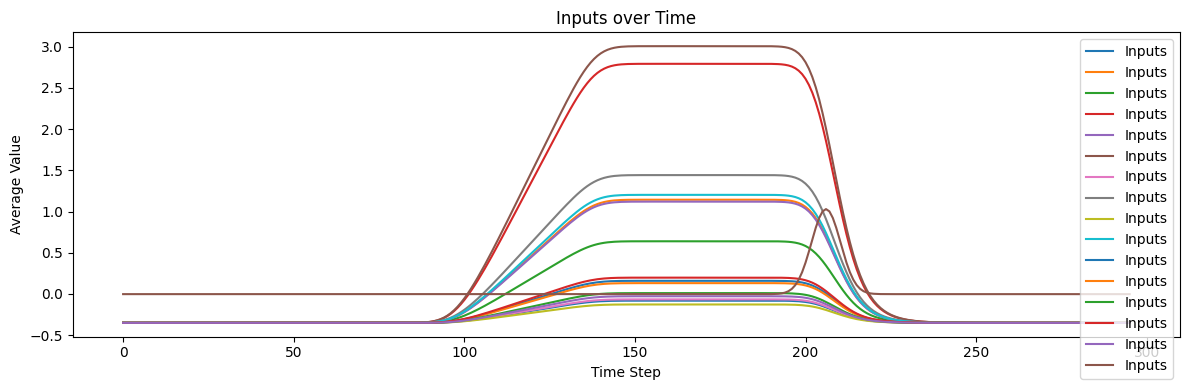

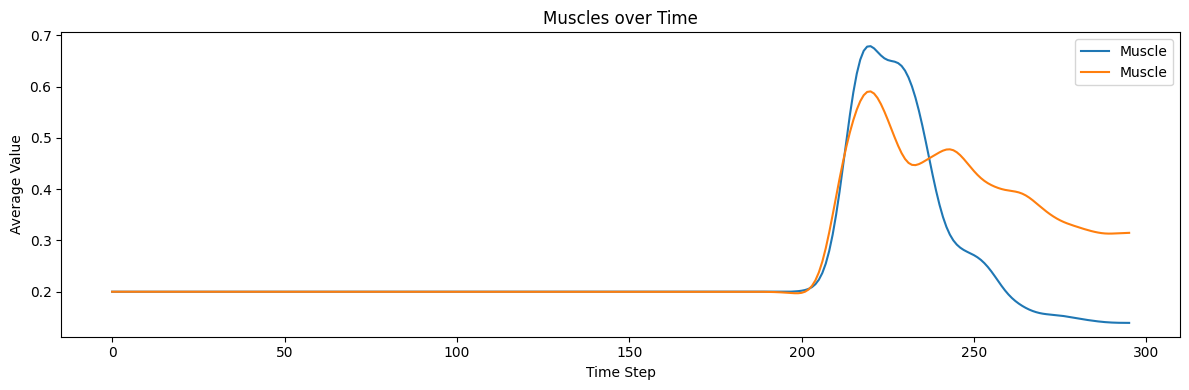

In [7]:
file_path = 'condsForSimJ2moMuscles.mat'  
normalised_inputs, output, num_conditions, num_delays = prepare_dataset(file_path)

# Averaging across conditions and delays
avg_inputs = normalised_inputs.mean(dim=[0, 1]).squeeze()
avg_output = output.mean(dim=[0, 1])

# Time steps
timesteps = np.arange(296)

plot_inputs_over_time(timesteps, avg_inputs)
plot_muscles_over_time(timesteps, avg_output)

In [8]:
class ComplicatedTimeseriesDataset(Dataset):
    def __init__(self, inputs, targets, delay_idx):
        """
        inputs: Tensor of shape [27, 8, 296, input_features]
        targets: Tensor of shape [27, 8, 296, output_features]
        delay_idx: Fixed index of the delay to be used
        """
        self.inputs = inputs[:, delay_idx]
        self.targets = targets[:, delay_idx]
        self.num_conditions = inputs.shape[0]

        print("Shape of inputs - ComplicatedRNN", self.inputs.shape)
        print("Shape of targets - ComplicatedRNN", self.targets.shape)

    def __len__(self):
        return self.num_conditions

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq

# Choose the delay index
fixed_delay_idx = 3

# Create the dataset with the fixed delay
complicated_dataset = ComplicatedTimeseriesDataset(normalised_inputs, output, fixed_delay_idx)

# Split the dataset
train_size = int(0.6 * len(complicated_dataset))
val_size = int(0.2 * len(complicated_dataset))
test_size = len(complicated_dataset) - train_size - val_size

complicated_train_dataset, complicated_val_dataset, complicated_test_dataset = random_split(complicated_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 1
complicated_train_loader = DataLoader(complicated_train_dataset, batch_size=batch_size, shuffle=True)
complicated_val_loader = DataLoader(complicated_val_dataset, batch_size=batch_size, shuffle=False)
complicated_test_loader = DataLoader(complicated_test_dataset, batch_size=batch_size, shuffle=False)


Shape of inputs - ComplicatedRNN torch.Size([27, 296, 16])
Shape of targets - ComplicatedRNN torch.Size([27, 296, 2])


In [9]:
# Flatten the first two dimensions (conditions and delays)
flattened_inputs = normalised_inputs.view(-1, *normalised_inputs.shape[2:])
flattened_targets = output.view(-1, *output.shape[2:])

class SimpleTimeseriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        
        print("Shape of inputs - SimpleRNN", self.inputs.shape)
        print("Shape of targets - SimpleRNN", self.targets.shape)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq

# Create the SimpleRNN dataset
simple_dataset = SimpleTimeseriesDataset(flattened_inputs, flattened_targets)

# Split the dataset
simple_train_size = int(0.6 * len(simple_dataset))
simple_val_size = int(0.2 * len(simple_dataset))
simple_test_size = len(simple_dataset) - simple_train_size - simple_val_size

simple_train_dataset, simple_val_dataset, simple_test_dataset = random_split(simple_dataset, [simple_train_size, simple_val_size, simple_test_size])

batch_size = 31

# Create DataLoaders
simple_train_loader = DataLoader(simple_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, worker_init_fn=seed_worker)
simple_val_loader = DataLoader(simple_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, worker_init_fn=seed_worker)
simple_test_loader = DataLoader(simple_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, worker_init_fn=seed_worker)


Shape of inputs - SimpleRNN torch.Size([216, 296, 16])
Shape of targets - SimpleRNN torch.Size([216, 296, 2])


In [10]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' 
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' 
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    return avg_test_loss


GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Random seed 2024 has been set.
Epoch 1, Training Loss: 0.06553341466933489
Epoch 1, Validation Loss: 0.008234785636886954
Epoch 2, Training Loss: 0.022627243772149086
Epoch 2, Validation Loss: 0.00929733831435442
Epoch 3, Training Loss: 0.013534704968333245
Epoch 3, Validation Loss: 0.005338804796338081
Epoch 4, Training Loss: 0.01285706888884306
Epoch 4, Validation Loss: 0.0014746577944606543
Epoch 5, Training Loss: 0.01154604870826006
Epoch 5, Validation Loss: 0.001675924751907587
Epoch 6, Training Loss: 0.010001416597515345
Epoch 6, Validation Loss: 0.0011503702262416482
Epoch 7, Training Loss: 0.009834299609065057
Epoch 7, Validation Loss: 0.0014997419202700257
Epoch 8, Training Loss: 0.009495840966701507
Epoch 8, Validation Loss: 0.001091476937290281
Epoch 9, Training Loss: 0.00949622131884098
Epoch 9, Validation Loss: 0.0016

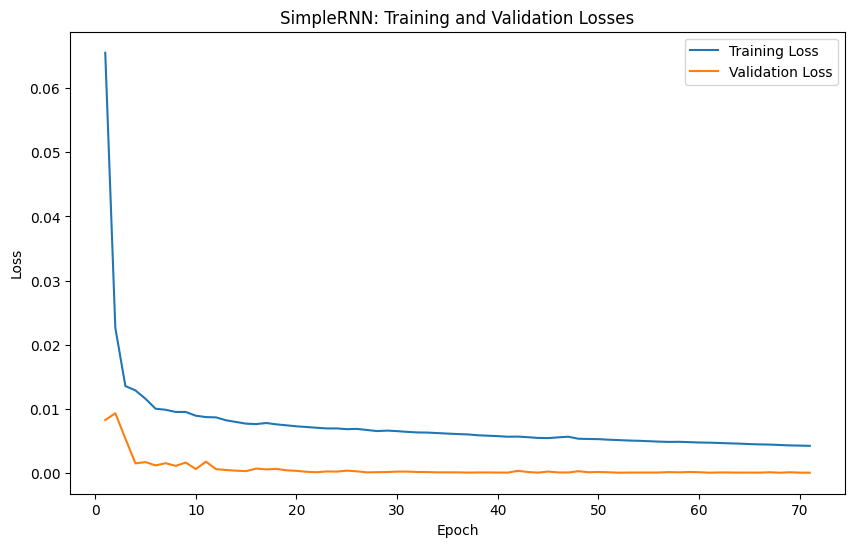

In [11]:
from torch.cuda.amp import autocast, GradScaler
from torch.autograd import profiler

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh 
         
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration    
        # Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1)) 
        input_update = torch.matmul(self.B, x.transpose(0, 1))        
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)    
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)    
        # Output calculation
        output = self.output_linear(firing_rate)    
        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum()
        dynamic_reg = torch.linalg.norm(torch.matmul(self.J, grad_rectified_tanh(hidden.transpose(0, 1))), ord='fro', dim=(-2, -1)).sum()
 
        return output, hidden, firing_rate_reg, dynamic_reg

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg

# Hyperparameters
input_size = 16 # Features + Go Cue
hidden_size = 150
output_size = 2  # Number of muscles
g = 1.5  # g value
h_val = 1.0  # h value

# Hyperparameters for regularization
alpha = 1e-5  
beta = 0.003
gamma = 1e-6

# Training Loop
num_epochs = 100
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
device = set_device()

# Model instantiation
set_seed(seed=2024) 
model = SimpleRNN(input_size, hidden_size, output_size, g, h_val)
model.to(device)

# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0) ### WD=0. Note: Paper uses Hessian-Free optimizer
scaler = GradScaler()

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode

    # Initialize hidden states 
    hidden_states_for_plot = []

    for inputs, targets in simple_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad() 

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        with autocast():  # Enable automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
                hidden_states_for_plot.append(h.detach().cpu().numpy())
                total_firing_rate_reg += firing_rate_reg
                total_dynamic_reg += dynamic_reg

            # Compute loss and regularization terms
            loss = criterion(output, targets[:, -1, :])
            l2_reg = compute_l2_regularization(model.parameters(), alpha)
            rfr_reg = beta * total_firing_rate_reg / inputs.shape[1] / hidden_size / num_conditions #CNT where C is 27 conditions, N is 300 neurons and T is 296 timesteps
            rj_reg = gamma * total_dynamic_reg / inputs.shape[1] / num_conditions #CT
            total_loss = loss + l2_reg + rfr_reg + rj_reg

        scaler.scale(total_loss).backward()  # Scale loss and perform backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        scaler.step(optimizer)  # Update optimizer
        scaler.update()  # Update scaler

        running_loss += total_loss.item()

    avg_loss = running_loss / len(simple_train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(model, simple_val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(model, simple_test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

# Call the plotting function
plot_training_validation_losses(epoch_losses, val_losses, actual_num_epochs, "SimpleRNN: Training and Validation Losses")

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Epoch 1, Training Loss: 0.011651251452349243
Epoch 1, Validation Loss: 0.0053141192358452825
Epoch 2, Training Loss: 0.00467482822148213
Epoch 2, Validation Loss: 0.004860778292641044
Epoch 3, Training Loss: 0.008090370567515492
Epoch 3, Validation Loss: 0.001484037582122255
Epoch 4, Training Loss: 0.003237112031797551
Epoch 4, Validation Loss: 0.0035062197071965783
Epoch 5, Training Loss: 0.0032143877006092225
Epoch 5, Validation Loss: 0.0010778766125440597
Epoch 6, Training Loss: 0.0019266203526058234
Epoch 6, Validation Loss: 0.000346692162565887
Epoch 7, Training Loss: 0.001757630466727278
Epoch 7, Validation Loss: 0.002167232520878315
Epoch 8, Training Loss: 0.0012461506657928112
Epoch 8, Validation Loss: 0.000575147270137677
Epoch 9, Training Loss: 0.0011469399433394756
Epoch 9, Validation Loss: 0.0017380144796334206
Epoch 1

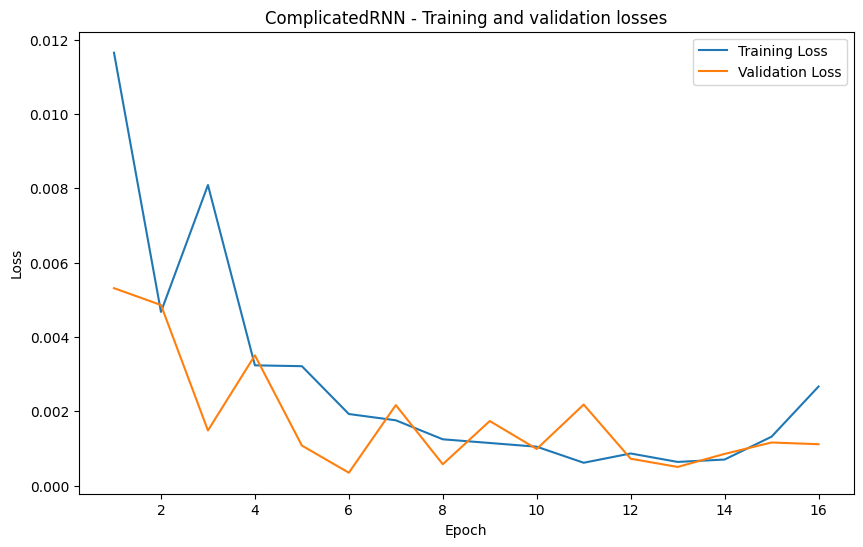

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2

# ComplicatedRNN class
class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Weight initialization (unchanged)
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity (unchanged)
        self.nonlinearity = rectified_tanh 
        
    def forward(self, x, hidden):
        # Forward pass logic (same as SimpleRNN but without regularization terms)
        hidden_prev = hidden.clone()
        timestep = self.tau / 10
        #Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1))
        input_update = torch.matmul(self.B, x.transpose(0, 1))     
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)
        output = self.output_linear(firing_rate)
        
        return output, hidden
        
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

# Training loop
# Hyperparameters
input_size = 16
hidden_size = 300
output_size = 2  # Number of muscles
g = 4  # g value
h_val = 1.0  # h value

# Training Loop
num_epochs = 100
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
device = set_device()

# Model instantiation
complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h_val)
complicated_model.to(device)

# Loss function and optimizer (no weight decay)
criterion = nn.MSELoss()
optimizer = optim.Adam(complicated_model.parameters(), lr=0.001, weight_decay=0)
scaler = GradScaler()

# Training loop 
for epoch in range(num_epochs):
    running_loss = 0.0
    hidden_states_for_plot_cm = []

    complicated_model.train()  # Set the model to training mode
    for inputs, targets in complicated_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = complicated_model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()

        with autocast():  # Apply automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h = complicated_model(inputs[:, t, :], h)
                hidden_states_for_plot_cm.append(h.detach().cpu().numpy())

            loss = criterion(output, targets[:, -1, :])

        scaler.scale(loss).backward()  # Scale loss for backward pass
        scaler.step(optimizer)  # Update optimizer with scaled gradients
        scaler.update()  # Update the scaler

        running_loss += loss.item()

    avg_loss = running_loss / len(complicated_train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(complicated_model, complicated_val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(complicated_model, complicated_test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

# Call the plotting function
plot_training_validation_losses(epoch_losses, val_losses, actual_num_epochs, "ComplicatedRNN - Training and validation losses")


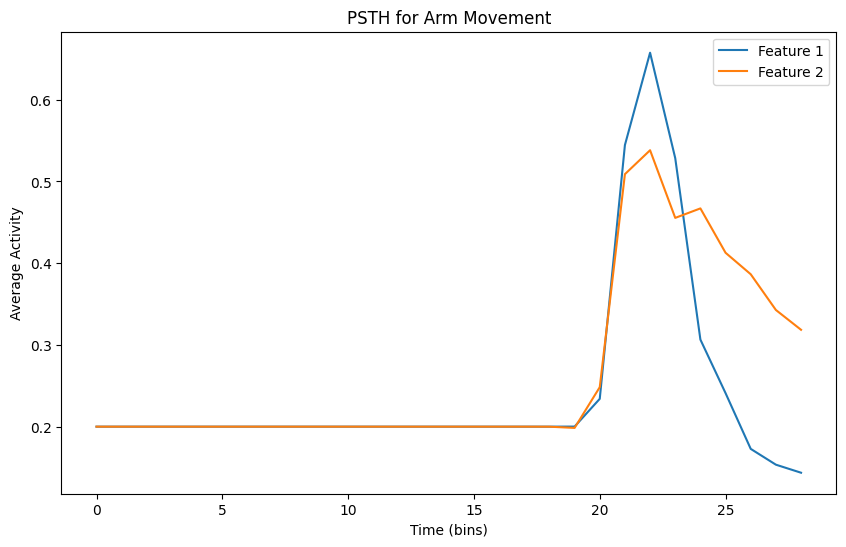

In [13]:
file_path = 'condsForSimJ2moMuscles.mat'  
normalised_inputs, output, num_conditions, num_delays = prepare_dataset(file_path)

# Plot PSTH for arm movement
plot_psth(output, "PSTH for Arm Movement")

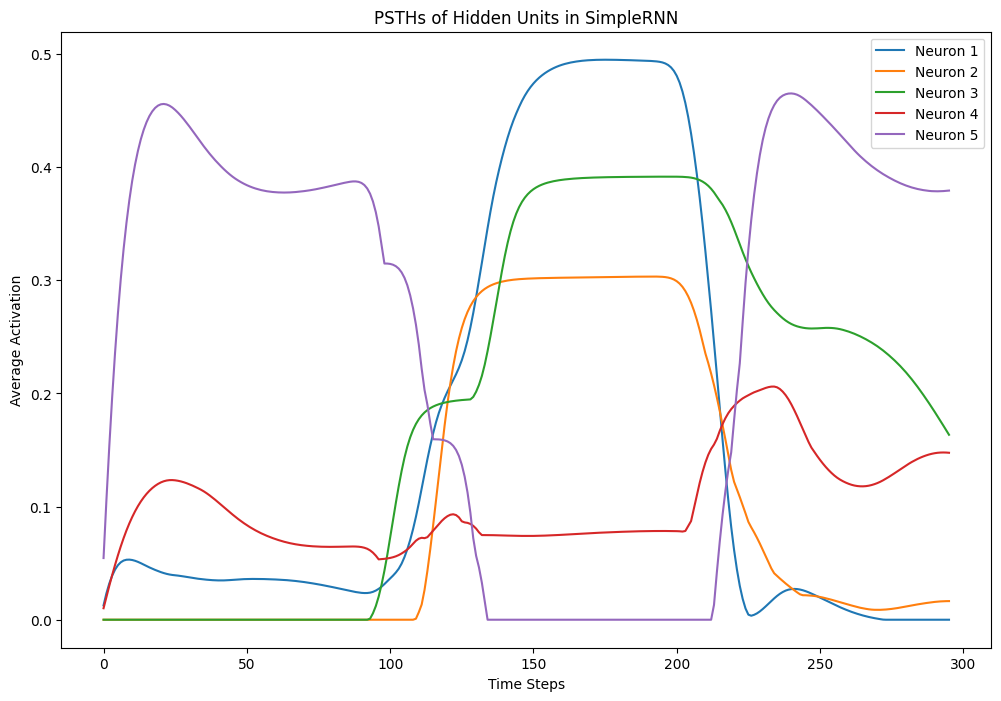

In [14]:
# Plot hidden units in SimpleRNN
plot_hidden_unit_activations(hidden_states=hidden_states_for_plot, timesteps=296, neurons_to_plot=5, title='PSTHs of Hidden Units in SimpleRNN')

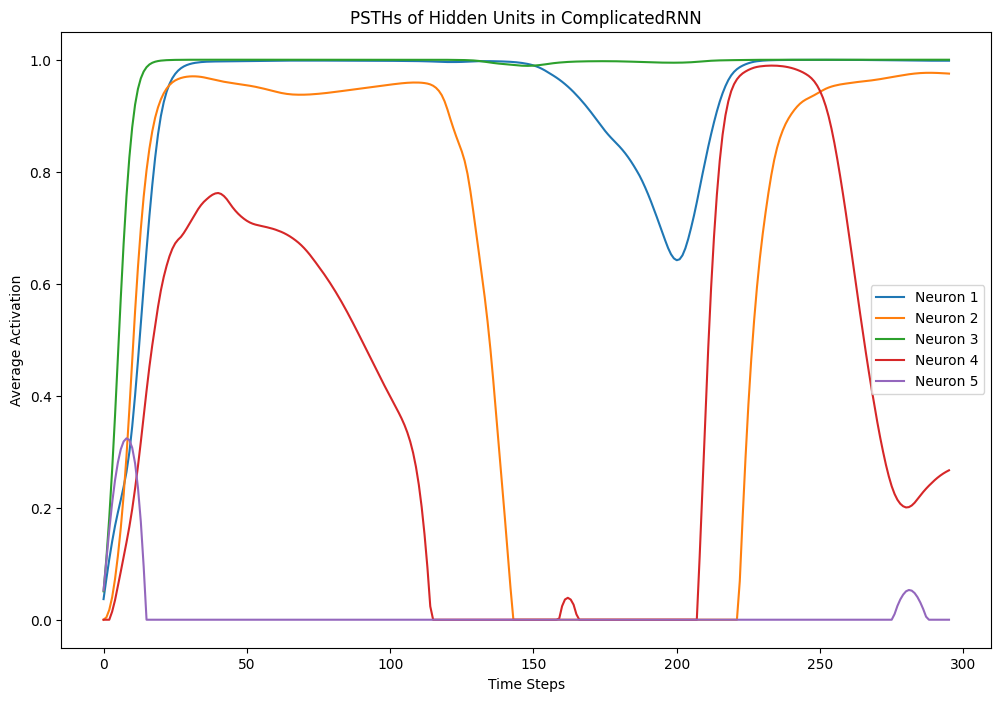

In [15]:
# Plot hidden units in ComplicatedRNN
plot_hidden_unit_activations(hidden_states=hidden_states_for_plot_cm, timesteps=296, neurons_to_plot=5, title='PSTHs of Hidden Units in ComplicatedRNN')

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def perturb_inputs(model, inputs, perturbation_strength):
    device = inputs.device
    # Perturb the inputs by adding random noise scaled by the perturbation strength and input strength
    input_strength = torch.norm(inputs, p=2, dim=-1, keepdim=True)  # Calculate the L2 norm of inputs
    noise = torch.rand(inputs.shape[0], 1, inputs.shape[2], device=device) * perturbation_strength * input_strength    
    perturbed_inputs = inputs + noise
    return perturbed_inputs

def compute_loss(model, inputs, targets, criterion, device):
    batch_size = inputs.size(0)
    h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
    losses = []
    for t in range(inputs.shape[1]):  # Iterate over time steps
        model_output = model(inputs[:, t, :], h)
        output, h, *rest = model_output[:2]
        loss = criterion(output, targets[:, t])  # Assume targets is a sequence of same length as inputs
        losses.append(loss)
    mean_loss = torch.mean(torch.stack(losses)).item()
    return mean_loss

def test_perturbed_inputs(model, perturbation_strengths, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    perturbation_results = []

    for strength in perturbation_strengths:
        all_errors = []  # Store all errors for each perturbation strength to compute mean and s.d.
        print(f"Testing perturbation strength {strength}")
        for iteration in range(20):  # Repeat the procedure 20 times
            batch_errors = []  # Store errors for each batch
            print(f" Iteration {iteration+1}/50")
            
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                # Compute error for original inputs
                original_loss = compute_loss(model, inputs, targets, criterion, device)
                # Compute error for perturbed inputs
                perturbed_inputs = perturb_inputs(model, inputs, strength)
                perturbed_loss = compute_loss(model, perturbed_inputs, targets, criterion, device)
                
                # Store the normalized error difference
                error_diff = abs(perturbed_loss - original_loss) / original_loss * 100  # Normalize as percentage
                error_diff = min(error_diff, 100)  # Truncate at 100%
                batch_errors.append(error_diff)
            
            all_errors.extend(batch_errors)
        
        mean_error = np.mean(all_errors)
        std_error = np.std(all_errors)
        perturbation_results.append((mean_error, std_error))
        print(f"Completed testing for perturbation strength {strength}.")
    
    return perturbation_results

import time

# Start time
start_time = time.time()

perturbation_strengths = [0.01, 0.1, 1]
results_complex = test_perturbed_inputs(complicated_model, perturbation_strengths, complicated_train_loader, criterion, device)
results_simple = test_perturbed_inputs(model, perturbation_strengths, simple_train_loader, criterion, device)

end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Testing perturbation strength 0.01
 Iteration 1/50
 Iteration 2/50
 Iteration 3/50
 Iteration 4/50
 Iteration 5/50
 Iteration 6/50
 Iteration 7/50
 Iteration 8/50
 Iteration 9/50
 Iteration 10/50
 Iteration 11/50
 Iteration 12/50
 Iteration 13/50
 Iteration 14/50
 Iteration 15/50
 Iteration 16/50
 Iteration 17/50
 Iteration 18/50
 Iteration 19/50
 Iteration 20/50
Completed testing for perturbation strength 0.01.
Testing perturbation strength 0.1
 Iteration 1/50
 Iteration 2/50
 Iteration 3/50
 Iteration 4/50
 Iteration 5/50
 Iteration 6/50
 Iteration 7/50
 Iteration 8/50
 Iteration 9/50
 Iteration 10/50
 Iteration 11/50
 Iteration 12/50
 Iteration 13/50
 Iteration 14/50
 Iteration 15/50
 Iteration 16/50
 Iteration 17/50
 Iteration 18/50
 Iteration 19/50
 Iteration 20/50
Completed testing for perturbation strength 0.1.
Testing perturbation strength 1
 Iteration 1/50
 Iteration 2/50
 Iteration 3/50
 Iteration 4/50
 Iteration 5/50
 Iteration 6/50
 Iteration 7/50
 Iteration 8/50
 Iteration

SimpleRNN: mean errors (0.5714082670433895, 8.388139810450578, 58.39235536152401)
ComplicatedRNN: mean errors (1.8646218410130095, 15.864984871816793, 45.03025511830509)
SimpleRNN: normalised mean errors [0.9785669091538357, 14.365133515367159, 100.0]
ComplicatedRNN: normalised mean errors [4.1408200688941434, 35.23183430814624, 100.0]


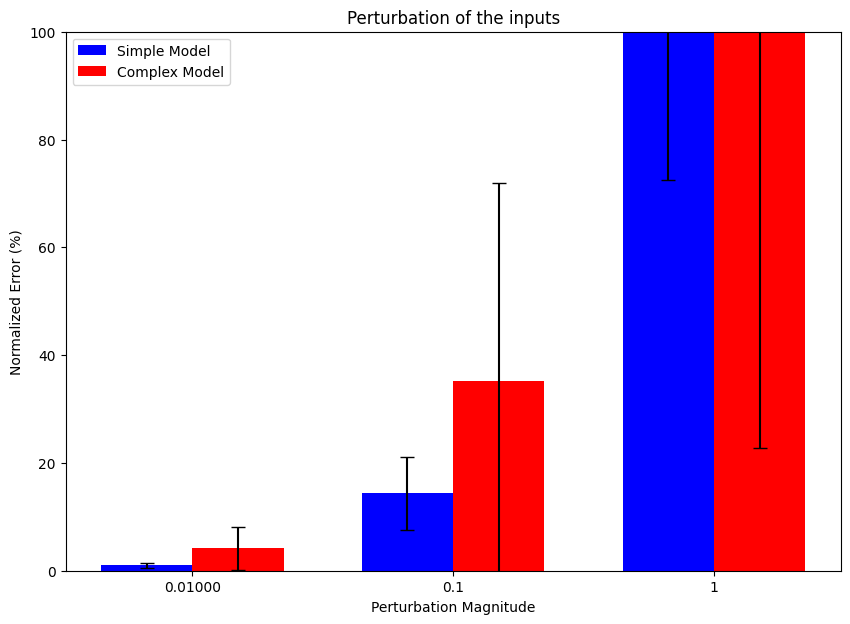

In [17]:
#Plot perturbation results
plot_perturbation_results(perturbation_strengths, results_simple, results_complex, "Perturbation of the inputs")


In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader

def calculate_mean_absolute_strength(model):
    # Calculate the mean absolute connection strength of the recurrent weight matrix
    return torch.mean(torch.abs(model.J)).item()

def perturb_recurrent_weights(model, mean_strength, perturbation_percentage):
    # Perturb the recurrent weight matrix J according to a normalized percentage of the mean absolute strength
    perturbation_strength = mean_strength * perturbation_percentage
    with torch.no_grad():
        noise = torch.randn_like(model.J) * perturbation_strength
        perturbed_weights = model.J + noise
        return perturbed_weights

def test_perturbed_structure(model, perturbation_percentages, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    mean_strength = calculate_mean_absolute_strength(model)
    perturbation_results = []  # List to store (mean error, std dev) tuples

    original_weights = model.J.data.clone()  # Save the original weights

    for percentage in perturbation_percentages:
        multiple_perturbations_error = []
        print(f"Testing perturbation percentage {percentage:.4f}")
        
        for perturbation in range(30):  # Perturb 50 times for each strength
            batch_errors = []
            perturbed_weights = perturb_recurrent_weights(model, mean_strength, percentage)
            model.J.data = perturbed_weights.data
            print(f" Perturbation {perturbation+1}/50")

            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                batch_size = inputs.size(0)
                h = model.init_hidden(batch_size).to(device)
                
                for t in range(inputs.shape[1]):
                    model_output = model(inputs[:, t, :], h)
                    output, h = model_output[:2]  
                
                loss = criterion(output, targets[:, -1, :]).item()
                batch_errors.append(loss)
            
            model.J.data = original_weights.data  # Reset to original weights after each perturbation
            multiple_perturbations_error.append(np.mean(batch_errors))
        
        mean_error = np.mean(multiple_perturbations_error)  # Average over the 50 perturbations
        std_dev_error = np.std(multiple_perturbations_error)  # Standard deviation for error bars
        perturbation_results.append((mean_error, std_dev_error))
        print(f"Completed testing for perturbation percentage {percentage:.4f}. Mean error: {mean_error:.4f}, Std. dev.: {std_dev_error:.4f}\n")
    
    return perturbation_results

import time

# Start time
start_time = time.time()

# Define perturbation strengths as percentages
perturbation_strengths = [0.01, 0.1, 1]

# Function calls for simple and complex models
simple_model_errors_2 = test_perturbed_structure(model, perturbation_strengths, simple_train_loader, criterion, device)
complex_model_errors_2 = test_perturbed_structure(complicated_model, perturbation_strengths, complicated_train_loader, criterion, device)

end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Testing perturbation percentage 0.0100
 Perturbation 1/50
 Perturbation 2/50
 Perturbation 3/50
 Perturbation 4/50
 Perturbation 5/50
 Perturbation 6/50
 Perturbation 7/50
 Perturbation 8/50
 Perturbation 9/50
 Perturbation 10/50
 Perturbation 11/50
 Perturbation 12/50
 Perturbation 13/50
 Perturbation 14/50
 Perturbation 15/50
 Perturbation 16/50
 Perturbation 17/50
 Perturbation 18/50
 Perturbation 19/50
 Perturbation 20/50
 Perturbation 21/50
 Perturbation 22/50
 Perturbation 23/50
 Perturbation 24/50
 Perturbation 25/50
 Perturbation 26/50
 Perturbation 27/50
 Perturbation 28/50
 Perturbation 29/50
 Perturbation 30/50
Completed testing for perturbation percentage 0.0100. Mean error: 0.0000, Std. dev.: 0.0000

Testing perturbation percentage 0.1000
 Perturbation 1/50
 Perturbation 2/50
 Perturbation 3/50
 Perturbation 4/50
 Perturbation 5/50
 Perturbation 6/50
 Perturbation 7/50
 Perturbation 8/50
 Perturbation 9/50
 Perturbation 10/50
 Perturbation 11/50
 Perturbation 12/50
 Pertur

SimpleRNN: mean errors (2.0895431010406662e-05, 0.00015840785109806648, 0.015257670211140066)
ComplicatedRNN: mean errors (0.0007011761118519644, 0.0015986587485789035, 0.05139693182519901)
SimpleRNN: normalised mean errors [0.1369503385592271, 1.0382178203223211, 100.0]
ComplicatedRNN: normalised mean errors [1.364237293845992, 3.1104166957201698, 100.0]


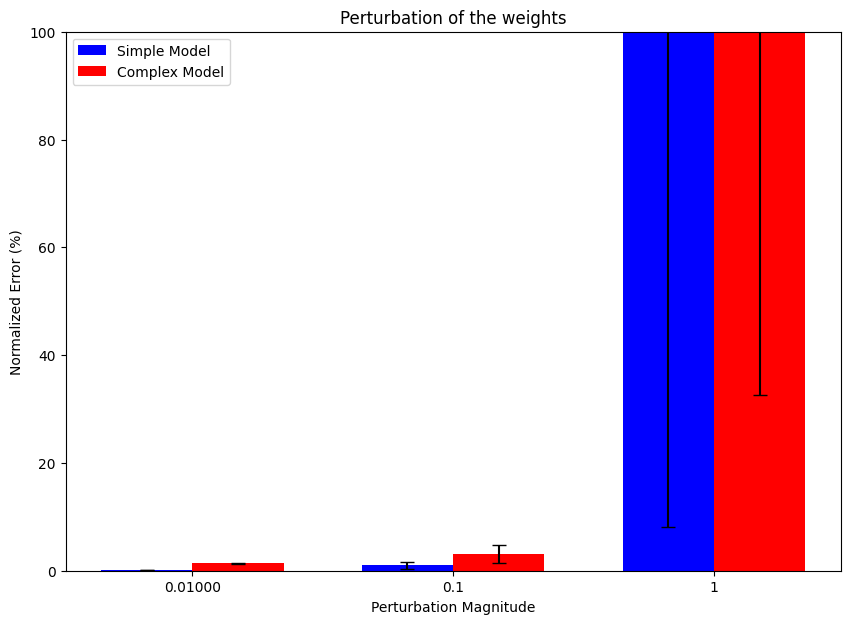

In [19]:
#Plot perturbation results
plot_perturbation_results(perturbation_strengths, simple_model_errors_2, complex_model_errors_2, "Perturbation of the weights")
